## EDA

EDA básico con comparación del dataset de kaggle y el dataset original.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import re

Both datasets loaded successfully.

--- Data Shapes ---
Competition Train Shape: (517754, 14)
Original Dataset Shape:  (111961, 13)

--- Missing Values (Competition) ---
0

--- Missing Values (Original) ---
0

--- Comparing Target Variable: accident_risk ---


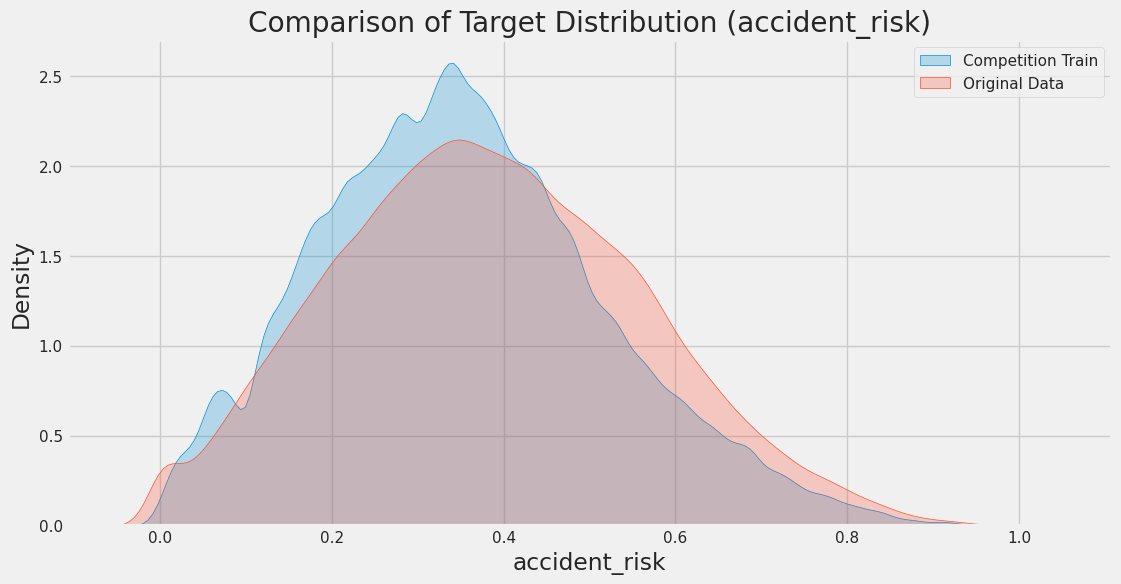


--- Comparing Numeric Feature Distributions ---


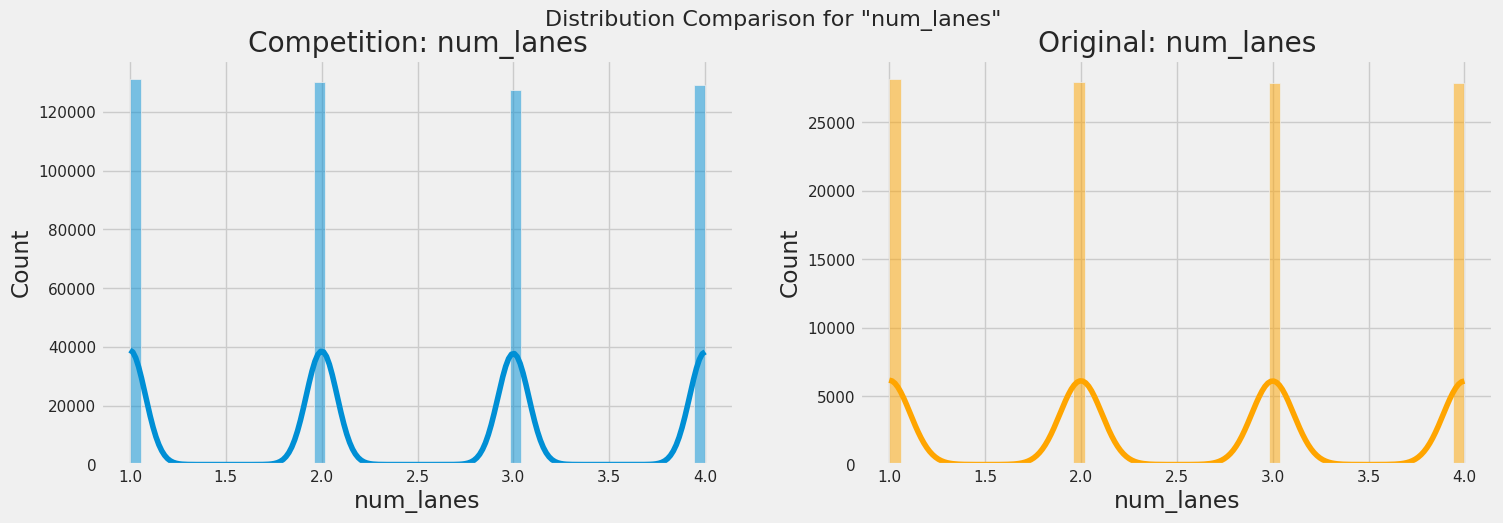

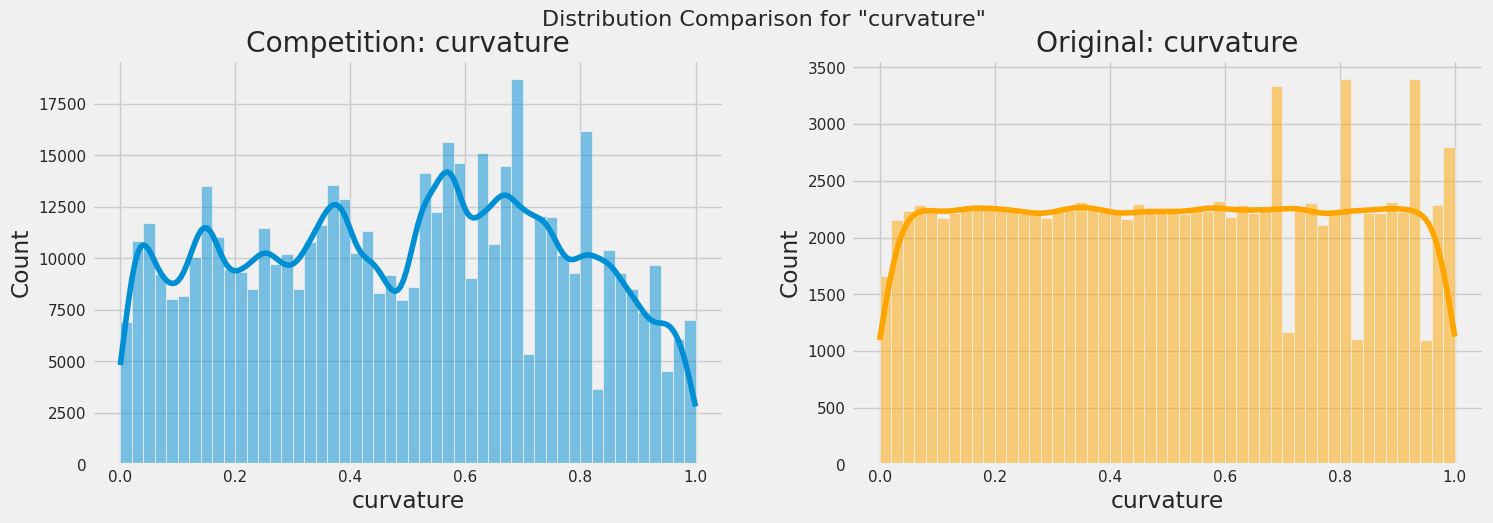

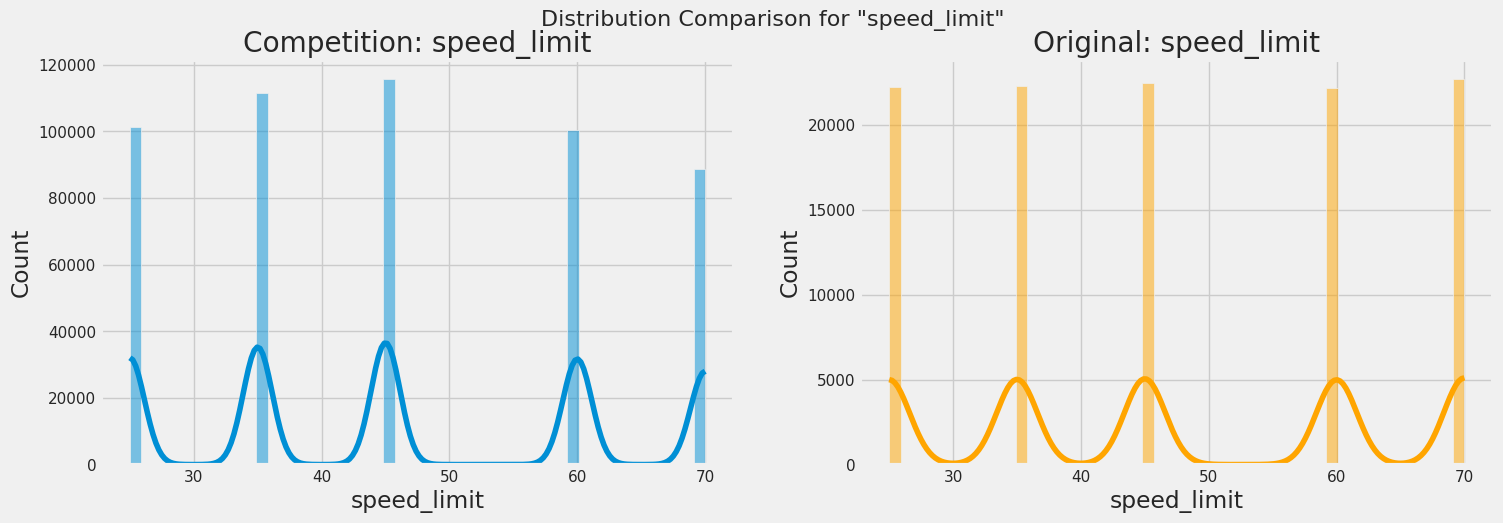

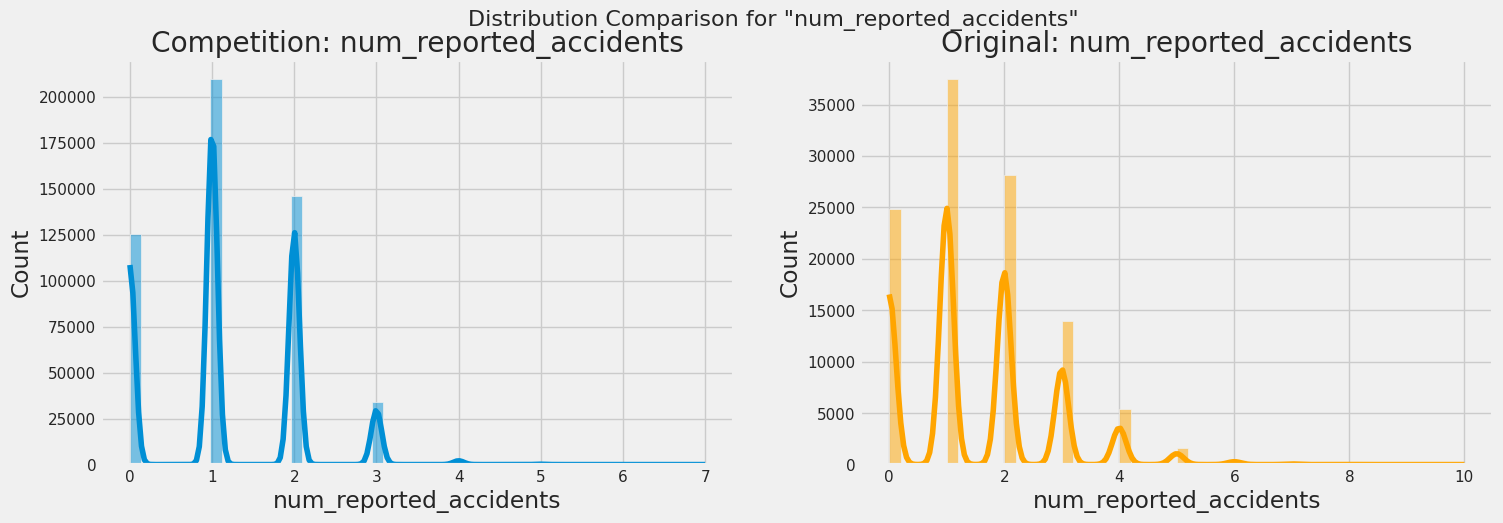


--- Target vs. Numeric Features ---


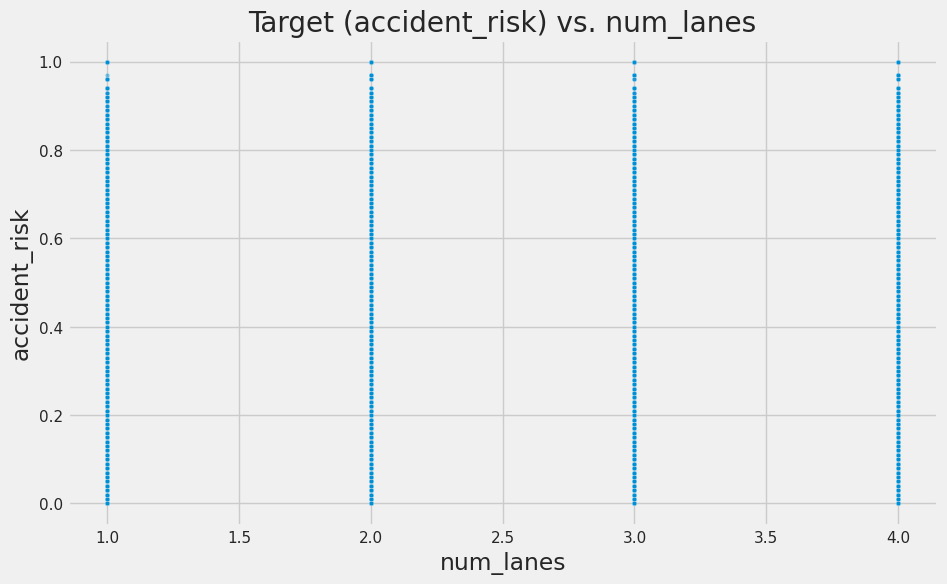

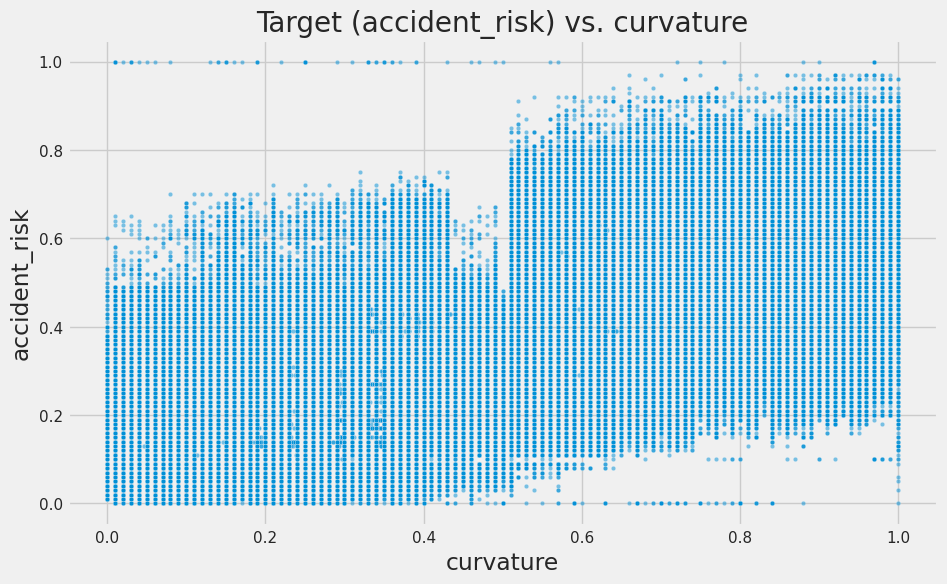

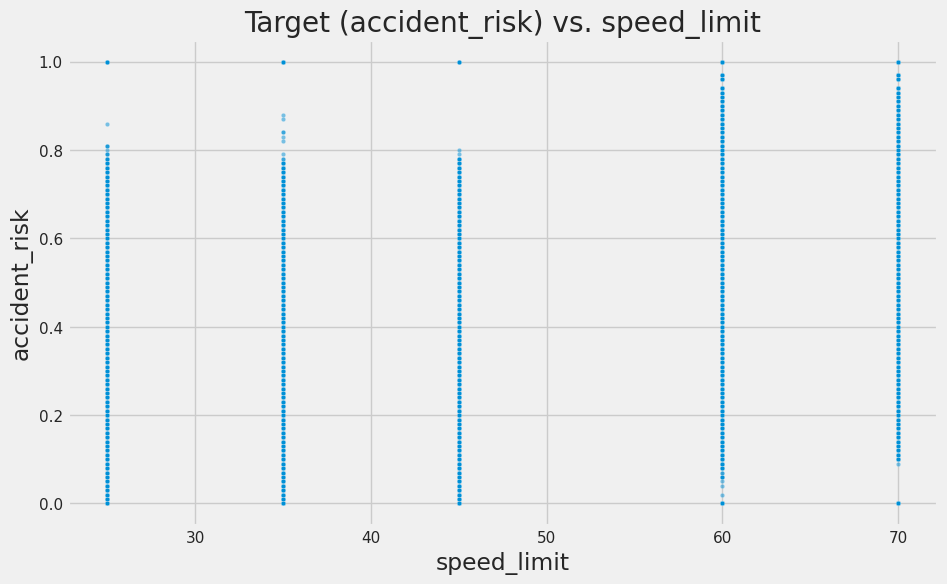

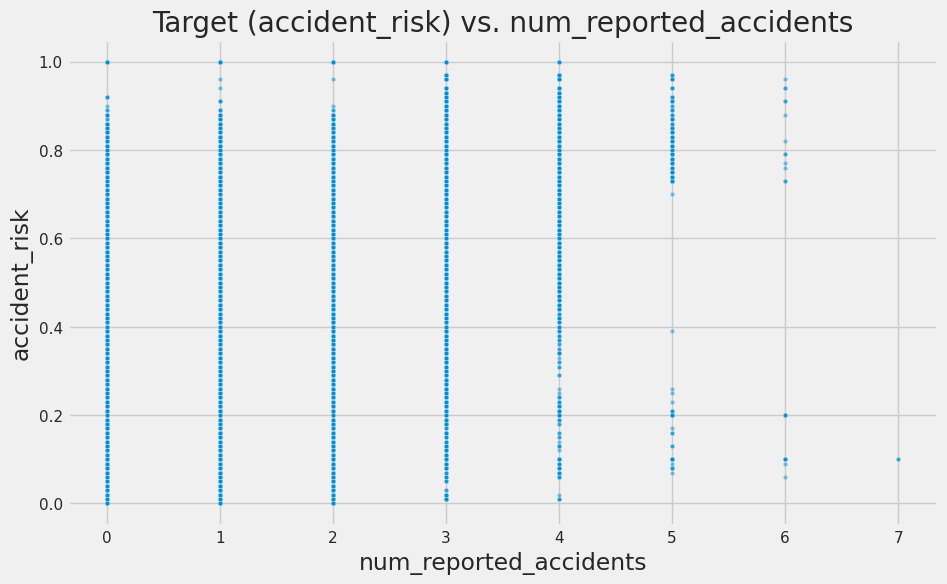


--- Target vs. Categorical Features ---


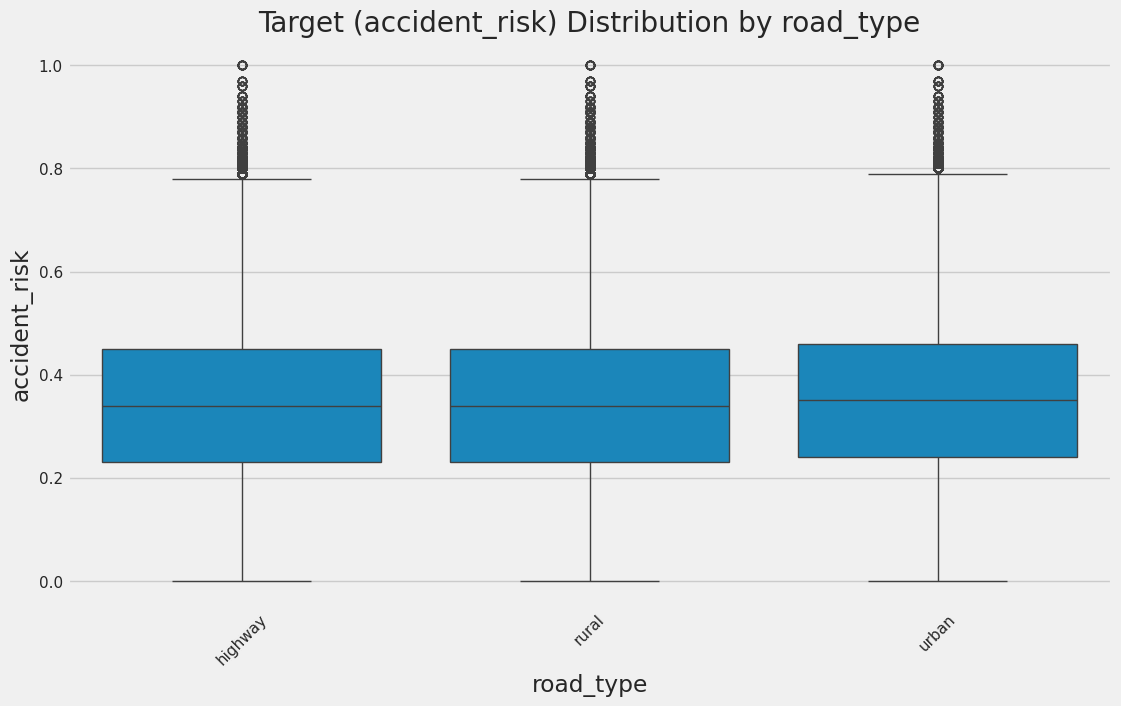

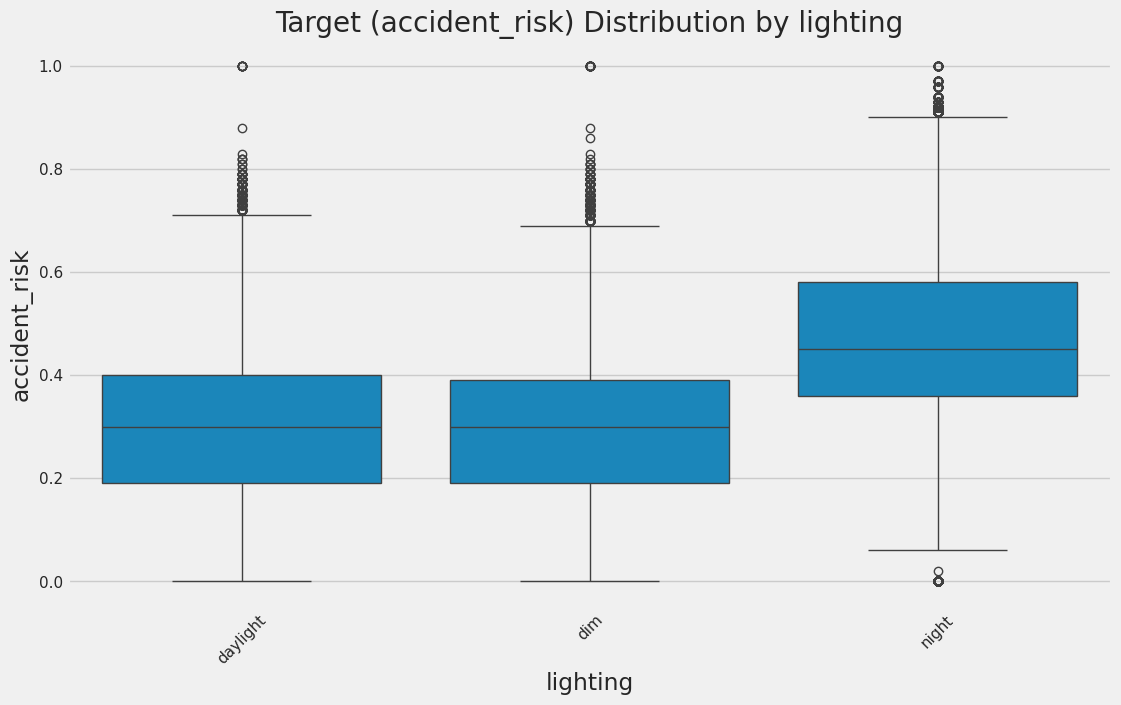

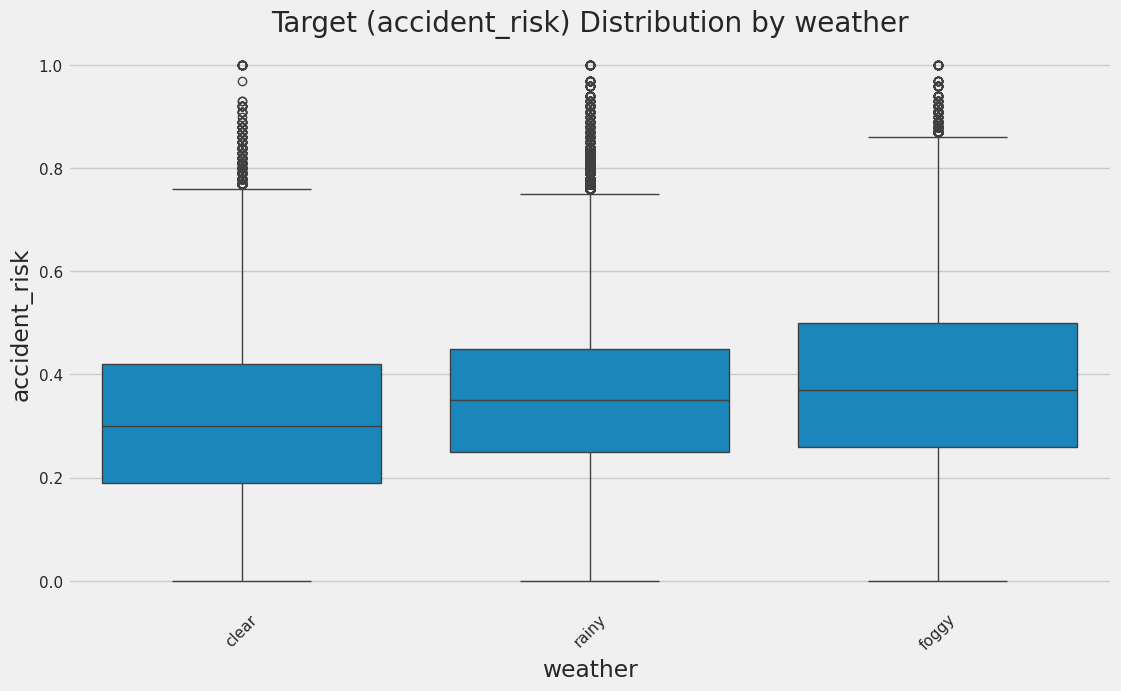

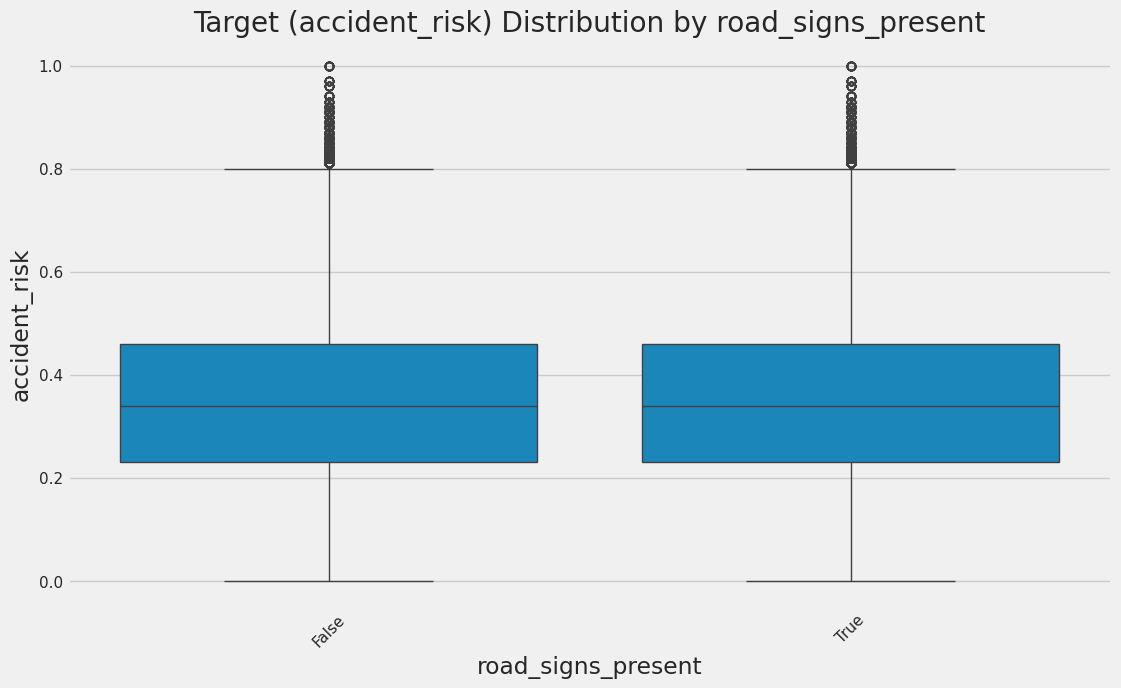

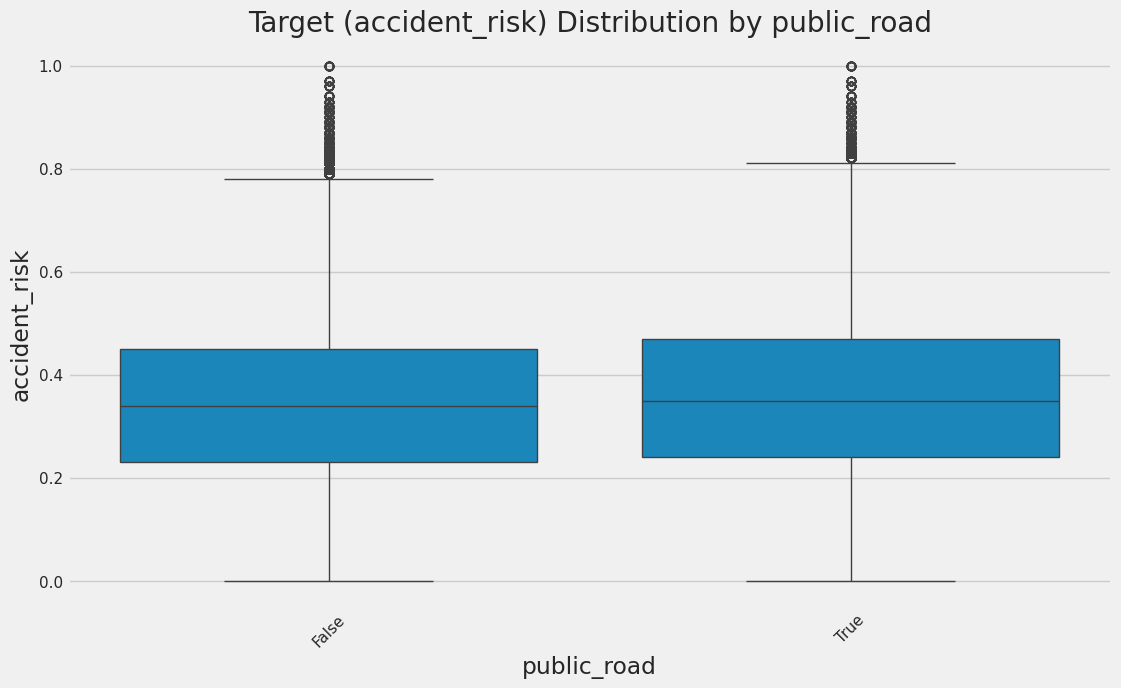

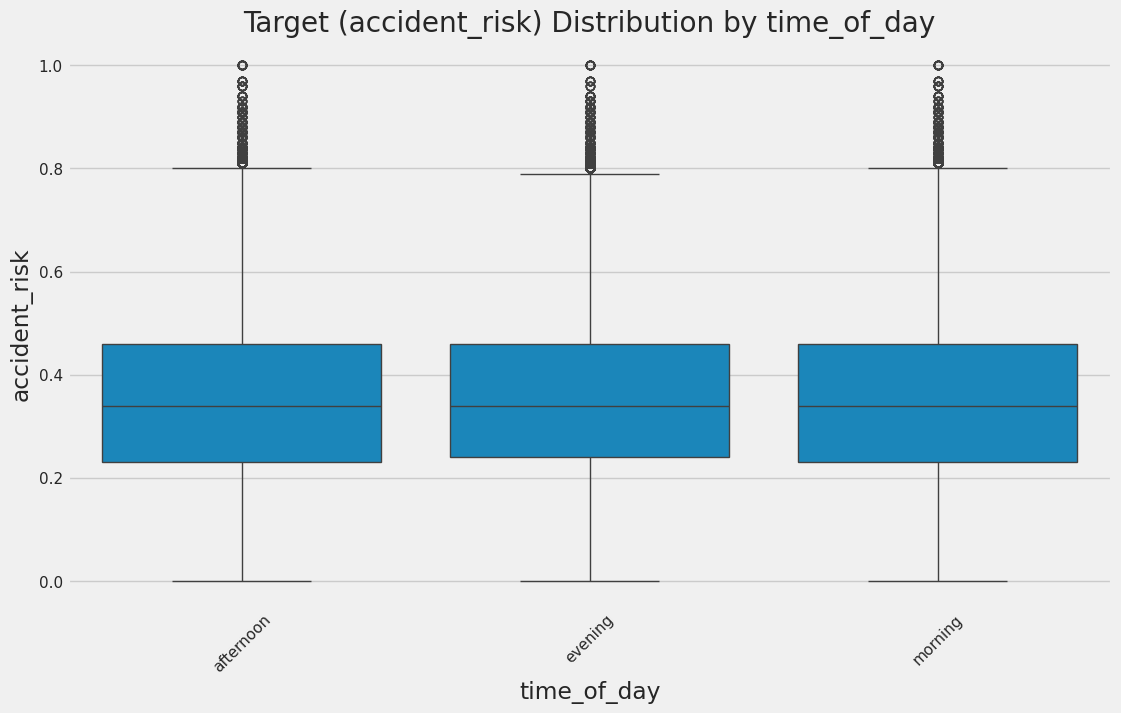

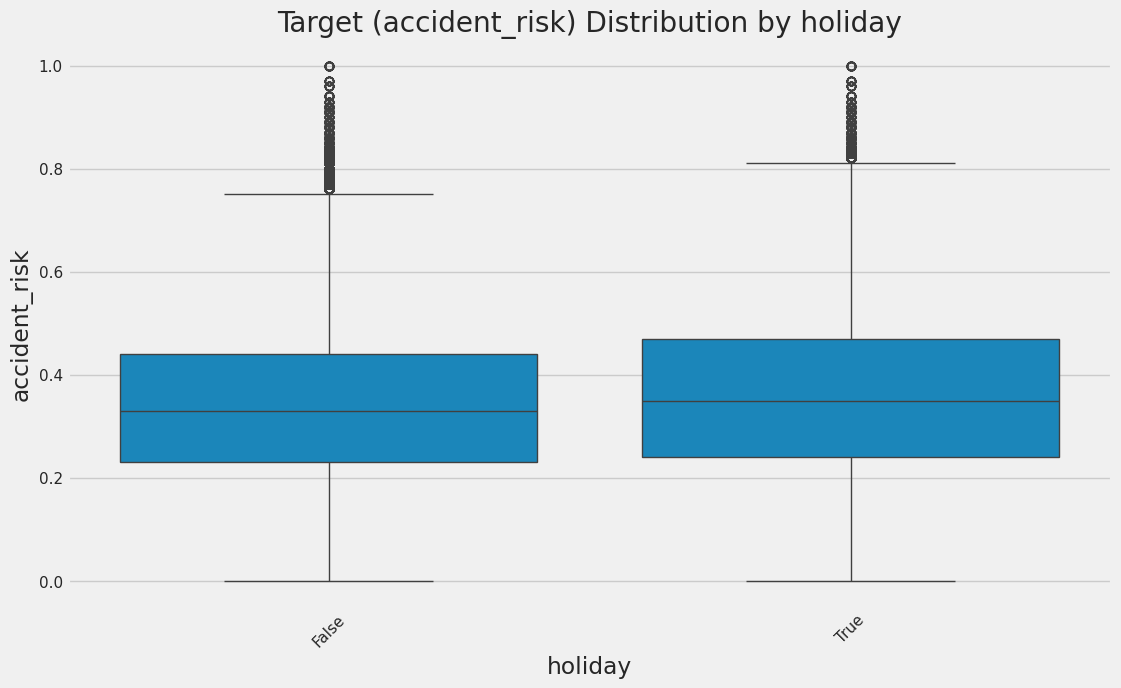

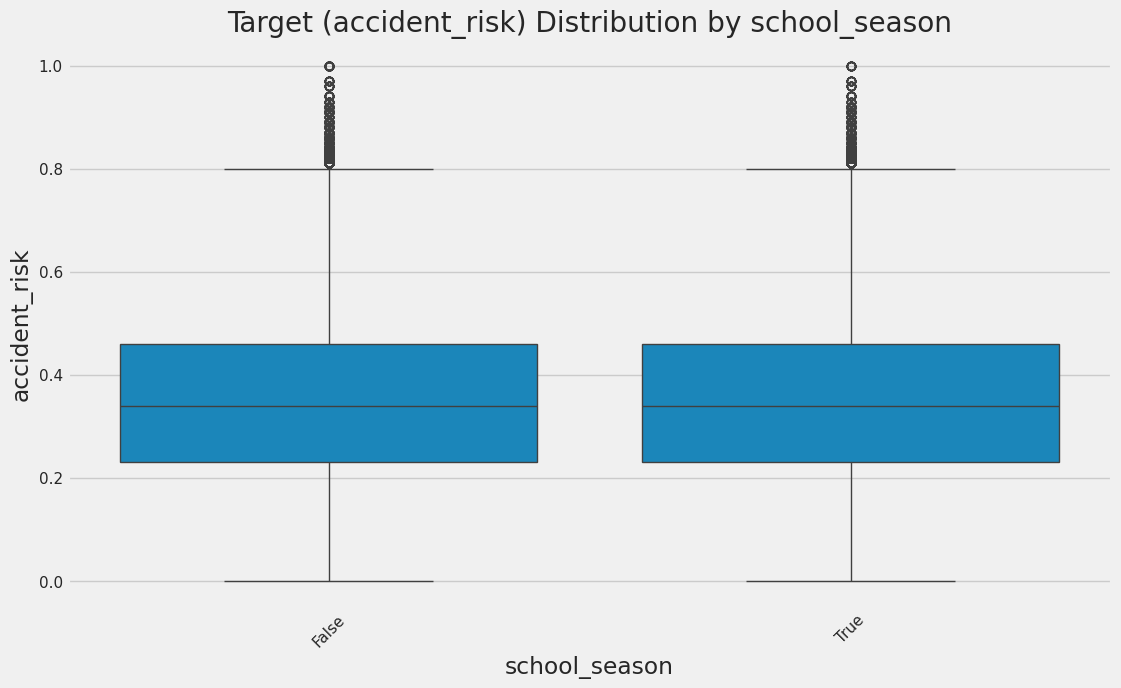

In [ ]:


# --- 1. Configuration & Data Loading ---
sns.set_theme(style="whitegrid", palette="muted")
plt.style.use("fivethirtyeight")

try:
    # Load the competition training data
    df_train = pd.read_csv('data/train.csv')
    # Load the original synthetic data
    df_orig = pd.read_csv('data/synthetic_road_accidents.csv')
    print("Both datasets loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading datasets: {e}")
    print("Please ensure 'train.csv' and 'synthetic_road_accidents.csv' are in the 'data/' folder.")
    exit()

# --- 2. Initial Data Audit ---
print("\n--- Data Shapes ---")
print(f"Competition Train Shape: {df_train.shape}")
print(f"Original Dataset Shape:  {df_orig.shape}")

print("\n--- Missing Values (Competition) ---")
print(df_train.isnull().sum().sum())

print("\n--- Missing Values (Original) ---")
print(df_orig.isnull().sum().sum())


# --- 3. Feature & Target Identification ---
TARGET = 'accident_risk'
features = [col for col in df_train.columns if col not in ['id', TARGET]]
numeric_features = df_train[features].select_dtypes(include=np.number).columns
categorical_features = df_train[features].select_dtypes(include=['object', 'bool']).columns


# --- 4. Comparative Visualizations ---

# Compare distributions of the target variable
print("\n--- Comparing Target Variable: accident_risk ---")
plt.figure(figsize=(12, 6))
sns.kdeplot(df_train[TARGET], label='Competition Train', fill=True)
sns.kdeplot(df_orig[TARGET], label='Original Data', fill=True)
plt.title('Comparison of Target Distribution (accident_risk)')
plt.legend()
plt.show()


# Compare distributions of numeric features
print("\n--- Comparing Numeric Feature Distributions ---")
for col in numeric_features:
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))

    # Competition Data Plot
    sns.histplot(df_train[col], ax=ax[0], kde=True, bins=50)
    ax[0].set_title(f'Competition: {col}')

    # Original Data Plot
    sns.histplot(df_orig[col], ax=ax[1], kde=True, bins=50, color='orange')
    ax[1].set_title(f'Original: {col}')

    fig.suptitle(f'Distribution Comparison for "{col}"', fontsize=16)
    plt.show()


# --- 5. Target vs. Feature Analysis ---

# Visualize relationship between numeric features and the target
print("\n--- Target vs. Numeric Features ---")
for col in numeric_features:
    plt.figure(figsize=(10, 6))
    # Using a scatter plot with low alpha to see density
    sns.scatterplot(data=df_train, x=col, y=TARGET, alpha=0.5, s=10)
    plt.title(f'Target ({TARGET}) vs. {col}')
    plt.show()

# Visualize relationship between categorical features and the target
print("\n--- Target vs. Categorical Features ---")
for col in categorical_features:
    plt.figure(figsize=(12, 7))
    # Boxplot shows the distribution of the target for each category
    order = df_train.groupby(col)[TARGET].median().sort_values().index
    sns.boxplot(data=df_train, x=col, y=TARGET, order=order)
    plt.title(f'Target ({TARGET}) Distribution by {col}')
    plt.xticks(rotation=45)
    plt.show()

## Análisis de dataset de Kaggle vs dataset original

se entrena un modelo XGBoost que intente predecir si un dato en específico es sintético o real. para así determinar qué tan similares son. Usando las características más diferenciadoras se puede saber cuáles fueron las características más importantes que diferencian ambos datasets.




In [ ]:


print("Loading datasets...")
try:
    kaggle_df = pd.read_csv('data/train.csv')
    original_df = pd.read_csv('data/synthetic_road_accidents.csv')
except FileNotFoundError as e:
    print(f"Error: {e}. Please ensure both 'train.csv' and 'synthetic_road_accidents.csv' are in the correct directory.")
print("Datasets loaded successfully.")

kaggle_df['is_synthetic'] = 1
original_df['is_synthetic'] = 0
combined_df = pd.concat([
    kaggle_df.drop('accident_risk', axis=1),
    original_df.drop('accident_risk', axis=1)
], ignore_index=True).drop('id', axis=1)

print("Preprocessing data...")
categorical_features = combined_df.select_dtypes(include=['object', 'bool']).columns
numerical_features = combined_df.select_dtypes(include=np.number).columns.drop('is_synthetic')
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')
encoded_cats = encoder.fit_transform(combined_df[categorical_features])
encoded_cats_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(categorical_features))
X_processed = pd.concat([combined_df[numerical_features].reset_index(drop=True), encoded_cats_df], axis=1)
y = combined_df['is_synthetic']
X_processed.columns = [re.sub(r'[^A-Za-z0-9_]+', '', col) for col in X_processed.columns]

# --- 3. Adversarial Validation Modeling (Final Corrected Version) ---
print("Starting adversarial validation with XGBoost...")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []
feature_importances = pd.DataFrame(index=X_processed.columns)

for fold, (train_idx, val_idx) in enumerate(cv.split(X_processed, y)):
    print(f"--- Fold {fold+1}/5 ---")
    X_train, X_val = X_processed.iloc[train_idx], X_processed.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # CHANGE: Early stopping is now defined in the constructor
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        n_estimators=1000,
        learning_rate=0.05,
        early_stopping_rounds=50, # Correct placement
        random_state=42
    )
    
    # The .fit() call is now cleaner
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    preds = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, preds)
    auc_scores.append(auc)
    # Note: best_iteration is available if early stopping is used
    feature_importances[f'fold_{fold+1}'] = model.feature_importances_
    print(f"Fold {fold+1} AUC: {auc:.4f} (stopped at iteration {model.best_iteration})")

# --- 4. Results (Unchanged) ---
print("\n--- Adversarial Validation Results ---")
mean_auc = np.mean(auc_scores)
print(f"\nMean Cross-Validation AUC: {mean_auc:.4f}")
feature_importances['mean'] = feature_importances.mean(axis=1)
feature_importances.sort_values('mean', ascending=False, inplace=True)
print("\nTop 10 most differentiating features:")
print(feature_importances['mean'].head(10))

Loading datasets...
Datasets loaded successfully.
Preprocessing data...
Starting adversarial validation with XGBoost...
--- Fold 1/5 ---
Fold 1 AUC: 0.6768 (stopped at iteration 569)
--- Fold 2/5 ---
Fold 2 AUC: 0.6726 (stopped at iteration 461)
--- Fold 3/5 ---
Fold 3 AUC: 0.6760 (stopped at iteration 739)
--- Fold 4/5 ---
Fold 4 AUC: 0.6769 (stopped at iteration 556)
--- Fold 5/5 ---
Fold 5 AUC: 0.6773 (stopped at iteration 664)

--- Adversarial Validation Results ---

Mean Cross-Validation AUC: 0.6759

Top 10 most differentiating features:
num_reported_accidents    0.268428
curvature                 0.175141
lighting_night            0.115223
weather_rainy             0.097660
speed_limit               0.069305
holiday_True              0.062241
public_road_True          0.046872
weather_foggy             0.046517
lighting_dim              0.022994
num_lanes                 0.018044
Name: mean, dtype: float32


se generan nuevas características basadas en aquellas que más diferencian ambos datasets, con el fin de que en el entrenamiento se logre captar lo que diferencia al dataset original del sintético. ademas se agrega una columna que indique si el dato es sintético o real.

In [5]:


# --- 1. Load and Combine Data ---
print("Loading and combining datasets...")
try:
    kaggle_df = pd.read_csv('data/train.csv')
    original_df = pd.read_csv('data/synthetic_road_accidents.csv')
except FileNotFoundError as e:
    print(f"Error: {e}. Please ensure both files are in the directory.")
    exit()

kaggle_df['is_synthetic'] = 1
original_df['is_synthetic'] = 0
combined_df = pd.concat([kaggle_df, original_df], ignore_index=True)
combined_df = combined_df.drop('id', axis=1, errors='ignore')
print("Datasets combined.")

# --- 2. Feature Engineering ---
print("Creating new interaction features...")
# Feature 1: Risk Interaction
combined_df['risk_interaction'] = combined_df['num_reported_accidents'] * combined_df['curvature']
# Feature 2: Force Proxy
combined_df['force_proxy'] = combined_df['speed_limit']**2 * combined_df['curvature']
# Feature 3: High-Risk Condition
combined_df['is_rainy_night'] = ((combined_df['weather'] == 'rainy') & (combined_df['lighting'] == 'night')).astype(int)
print("New features created.")


# --- 3. Preprocessing ---
print("Preprocessing data...")
categorical_features = combined_df.select_dtypes(include=['object', 'bool']).columns
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')
encoded_cats = encoder.fit_transform(combined_df[categorical_features])
encoded_cats_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(categorical_features))

# Create the final features DataFrame (X)
X = pd.concat([
    combined_df.select_dtypes(include=np.number).drop('accident_risk', axis=1).reset_index(drop=True),
    encoded_cats_df
], axis=1)
X.columns = [re.sub(r'[^A-Za-z0-9_]+', '', col) for col in X.columns]

# Isolate the target variable (y)
y = combined_df['accident_risk']


# --- 4. Create and Save Final Dataset ---
print("Creating final dataset...")
# Combine the final features and the target variable
final_dataset = pd.concat([X, y.reset_index(drop=True)], axis=1)

# Save the new dataset to a CSV file
output_filename = 'data/engineered_features_dataset.csv'
final_dataset.to_csv(output_filename, index=False)

print(f"\n✅ Success! The new dataset with all engineered features has been saved as '{output_filename}'.")
print(f"Dataset has {final_dataset.shape[0]} rows and {final_dataset.shape[1]} columns.")

Loading and combining datasets...
Datasets combined.
Creating new interaction features...
New features created.
Preprocessing data...
Creating final dataset...

✅ Success! The new dataset with all engineered features has been saved as 'data/engineered_features_dataset.csv'.
Dataset has 629715 rows and 21 columns.


## Comparación de modelos lineales

se hace uso de validación cruzada para comparar 3 modelos lineales: regresión lineal, ridge y lasso.

In [ ]:


# --- 1. Cargar el Dataset ---
print("Cargando el dataset con características de ingeniería...")
try:
    final_dataset = pd.read_csv('data/engineered_features_dataset.csv')
except FileNotFoundError:
    print("Error: 'engineered_features_dataset.csv' no encontrado.")
    exit()
print("Dataset cargado.")

# --- 2. Preparar Datos (X y y) ---
X = final_dataset.drop('accident_risk', axis=1)
y = final_dataset['accident_risk']

# --- 3. Validación Cruzada para los 3 Modelos ---
print("Iniciando validación cruzada para los modelos lineales...")
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Diccionario para almacenar los resultados de cada modelo
results = {
    "Linear Regression": [],
    "Ridge": [],
    "Lasso": []
}

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"--- Fold {fold+1}/5 ---")
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Escalar los datos (paso crucial)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # Definir los modelos
    models = {
        "Linear Regression": LinearRegression(),
        "Ridge": Ridge(alpha=1.0, random_state=42),
        "Lasso": Lasso(alpha=0.0001, random_state=42, max_iter=2000) # Usamos un alpha pequeño para Lasso
    }

    # Entrenar y evaluar cada modelo
    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        preds = model.predict(X_val_scaled)
        rmse = np.sqrt(mean_squared_error(y_val, preds))
        results[name].append(rmse)
        print(f"  {name} RMSE: {rmse:.5f}")

# --- 4. Comparación Final ---
print("\n--- Comparación de Resultados (RMSE Promedio) ---")
avg_results = {}
for name, scores in results.items():
    avg_results[name] = np.mean(scores)
    print(f"  - {name}: {avg_results[name]:.5f}")



Cargando el dataset con características de ingeniería...
Dataset cargado.
Iniciando validación cruzada para los modelos lineales...
--- Fold 1/5 ---
  Linear Regression RMSE: 0.07284
  Ridge RMSE: 0.07284
  Lasso RMSE: 0.07284
--- Fold 2/5 ---
  Linear Regression RMSE: 0.07253
  Ridge RMSE: 0.07253
  Lasso RMSE: 0.07253
--- Fold 3/5 ---
  Linear Regression RMSE: 0.07218
  Ridge RMSE: 0.07218
  Lasso RMSE: 0.07218
--- Fold 4/5 ---
  Linear Regression RMSE: 0.07256
  Ridge RMSE: 0.07256
  Lasso RMSE: 0.07256
--- Fold 5/5 ---
  Linear Regression RMSE: 0.07228
  Ridge RMSE: 0.07228
  Lasso RMSE: 0.07228

--- Comparación de Resultados (RMSE Promedio) ---
  - Linear Regression: 0.07248
  - Ridge: 0.07248
  - Lasso: 0.07248


se observa que los resultados de los 3 modelos lineales son identicos. Se Opta por usar Ridge.

## Entrenamiento final y creación de archivo de predicciones
Se entrena el modelo ridge con los datos completos y se generan las predicciones para el dataset de prueba. Finalmente se crea el archivo de predicciones en el formato solicitado.

In [2]:

# --- 1. Cargar los Datasets ---
print("Cargando el dataset de entrenamiento pre-procesado y el test set en crudo...")
try:
    # Cargar el dataset de entrenamiento que ya tiene todas las características
    train_df = pd.read_csv('data/engineered_features_dataset.csv')
    # Cargar el dataset de prueba original para procesarlo
    test_df_raw = pd.read_csv('data/test.csv')
except FileNotFoundError as e:
    print(f"Error: {e}. Asegúrate de que los archivos estén en la carpeta 'data/'.")
    exit()

# Guardar los IDs del test set para el archivo de submission
test_ids = test_df_raw['id']

# --- 2. Preparar Datos de Entrenamiento ---
# El dataset de entrenamiento ya está listo. Solo separamos X y y.
X_train = train_df.drop('accident_risk', axis=1)
y_train = train_df['accident_risk']

# --- 3. Aplicar Ingeniería de Características al Test Set ---
print("Aplicando ingeniería de características al test set...")
def engineer_features(df):
    """Aplica las mismas transformaciones que al set de entrenamiento."""
    df_out = df.copy()
    df_out['risk_interaction'] = df_out['num_reported_accidents'] * df_out['curvature']
    df_out['force_proxy'] = (df_out['speed_limit'] ** 2) * df_out['curvature']
    df_out['is_rainy_night'] = ((df_out['weather'] == 'rainy') & (df_out['lighting'] == 'night')).astype(int)
    # is_synthetic no existe en el test set, lo añadimos con 1 por coherencia.
    df_out['is_synthetic'] = 1
    return df_out

test_featured = engineer_features(test_df_raw)

# --- 4. Preprocesamiento (One-Hot Encoding) del Test Set ---
print("Aplicando One-Hot Encoding al test set...")
# Usamos las columnas categóricas originales para el encoder
categorical_features = ['road_type', 'lighting', 'weather', 'road_signs_present', 'public_road', 'time_of_day', 'holiday', 'school_season']
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')

# Ajustar el encoder con las columnas categóricas del set de entrenamiento original (para asegurar consistencia)
# Esto es una buena práctica aunque no tengamos el df original aquí, definimos las columnas manualmente.
encoder.fit(pd.read_csv('data/train.csv')[categorical_features])

# Transformar el test set
test_encoded_cats = encoder.transform(test_featured[categorical_features])
test_encoded_df = pd.DataFrame(test_encoded_cats, columns=encoder.get_feature_names_out(categorical_features))

# Unir todo para crear el X_test final
X_test = pd.concat([
    test_featured.select_dtypes(include=np.number).drop(['id'], axis=1, errors='ignore').reset_index(drop=True),
    test_encoded_df
], axis=1)

# Alinear columnas para asegurar que X_test y X_train coincidan perfectamente
X_test.columns = [re.sub(r'[^A-Za-z0-9_]+', '', col) for col in X_test.columns]
X_test = X_test[X_train.columns] # Ordenar y seleccionar columnas para que coincidan

print("El test set ha sido procesado y alineado.")

# --- 5. Entrenar el Modelo Final y Hacer Predicciones ---
print("Entrenando el modelo Ridge final...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Ridge(alpha=1.0, random_state=42)
model.fit(X_train_scaled, y_train)
print("Modelo entrenado. Generando predicciones...")

predictions = model.predict(X_test_scaled)
# Asegurar que las predicciones estén en el rango [0, 1]
predictions = np.clip(predictions, 0, 1)

# --- 6. Crear el Archivo de Submission ---
print("Creando el archivo de submission...")
submission_df = pd.DataFrame({'id': test_ids, 'accident_risk': predictions})
submission_df.to_csv('submission.csv', index=False)

print("\n✅ ¡Éxito! El archivo 'submission.csv' ha sido creado y está listo para ser subido a Kaggle.")
print("Primeras 5 predicciones:")
print(submission_df.head())

Cargando el dataset de entrenamiento pre-procesado y el test set en crudo...
Aplicando ingeniería de características al test set...
Aplicando One-Hot Encoding al test set...
El test set ha sido procesado y alineado.
Entrenando el modelo Ridge final...
Modelo entrenado. Generando predicciones...
Creando el archivo de submission...

✅ ¡Éxito! El archivo 'submission.csv' ha sido creado y está listo para ser subido a Kaggle.
Primeras 5 predicciones:
       id  accident_risk
0  517754       0.365062
1  517755       0.172601
2  517756       0.201814
3  517757       0.432677
4  517758       0.335011
